In [3]:
#Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict, Counter
import os
import psycopg2
import textwrap


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


#setting no max column width
pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth')  #uncomment this if you want to deactivate it

#my functions
from text_utils import normalize_df_column, extract_recurrent_note_categories, filter_text,from_code_add_label_col

# Documents selection

In [3]:
# discharge_df = pd.read_csv("lab140discharge.csv")
# first_3_rows_df = pd.read_csv("first_3_rows.csv")

In [5]:
# discharge_df.drop(['label','target'],axis=1)
# first_3_rows_df.drop(['label','target'],axis=1)
# discharge_df = discharge_df.to_csv("lab140discharge0.csv")
# first_3_rows_df = first_3_rows_df.to_csv("first_3_rows0.csv")

In [2]:
PATH1 = "../../data/db/"
discharge_full_df = pd.read_csv(PATH1+"discharge.csv")

In [6]:
PATH1 = "../../data/db/mimic_note/"
df_filt = pd.read_csv(PATH1+"disharge_full_only_filtered_text.csv")

In [4]:
# # Create a new DataFrame with the first three rows
# df_first_3_rows = discharge_df.head(3)
# df_first_3_rows.to_csv('first_3_rows.csv', index=False) 

# Extracting categories

## Categories in full discharge notes of sentences repeated >10000

In [9]:
recurrent_sentences = extract_recurrent_note_categories(discharge_full_df)

# print each sentence on a new line
for sentence in recurrent_sentences:
    print(sentence)

MEDICINE
Adverse Drug Reactions
Chief Complaint
Past Medical History
Social History
Physical Exam
Pertinent Results
Brief Hospital Course
Discharge Medications
Discharge Disposition
Home
Discharge Diagnosis
Discharge Condition
Discharge Instructions
Followup Instructions
MICRO
FINAL REPORT ___
IMAGING
ADMISSION PHYSICAL EXAM
DISCHARGE PHYSICAL EXAM
ADMISSION LABS
Plt ___
STUDIES
DISCHARGE LABS
TRANSITIONAL ISSUES
Primary
Secondary
MICROBIOLOGY
CXR ___
CHRONIC ISSUES
Outpatient Lab Work
Facility
PRIMARY DIAGNOSIS
No
NEG
ACTIVE ISSUES
DISCHARGE EXAM
ORTHOPAEDICS
MEDICATIONS
Clear Sp ___
ADMISSION
DISCHARGE
NEGATIVE
HOLD
PND
Imaging
RANDOM
Clear SP ___
NAD
SURGERY
RA
Discharge Physical Exam
Extended Care
Transitional Issues
Hypertension
Admission Labs
Hyperlipidemia
ADMISSION EXAM
IMPRESSION
HTN
Primary Diagnosis
NEUROSURGERY
NC
Cranial Nerves
Penicillins
CTAB
ACUTE ISSUES
NEUROLOGY
Negative
HLD
Physical Therapy
Discharge Labs
CARDIOTHORACIC
Expired
Sliding Scale using HUM Insulin
Hypothy

In [10]:
print(len(recurrent_sentences))
#with repetition of sentences >30 we got 5848 in min 11
#with repetition of sentences >100 we got 2282 in min 9
#with repetition of sentences >1000 we got 310 in min 11.25 
#with repetition of sentences >10000 we got 37 in min 9  
#with repetition of sentences >10000 we got 112 in min 8.55  (including ___, excluding len<=1, 1st capital letter) 
#with repetition of sentences >10000 we got 100  in min 13.31  (including ___, excluding len<=1, 1st capital letter, excluding other words) 
#with repetition of sentences >10000 we got 80  in min 12  (changed of function to include again 1st letter capitalized and after normalizing the text, without putting everything in lower letters)

80


### Categories in lab140 >30
Adverse Drug Reactions
Chief Complaint
Past Medical History
Social History
Physical Exam
Pertinent Results
Brief Hospital Course
Discharge Medications
Discharge Disposition
Home
Discharge Diagnosis
Discharge Condition
Discharge Instructions
Followup Instructions
Facility
None

### This is the 37 list for recurrent (10000) sentences

Adverse Drug Reactions
Chief Complaint
Past Medical History
Social History
Physical Exam
Pertinent Results
Brief Hospital Course
Discharge Medications
Discharge Disposition
Home
Discharge Diagnosis
Discharge Condition
Discharge Instructions
Followup Instructions
Primary
Secondary
Outpatient Lab Work
Facility
None
Imaging
Discharge Physical Exam
Extended Care
Transitional Issues
Hypertension
Admission Labs
Hyperlipidemia
Primary Diagnosis
Cranial Nerves
Penicillins
Negative
Physical Therapy
Discharge Labs
Expired
Sliding Scale using HUM Insulin
Hypothyroidism
Depression
Denies

### This is the 80 list for recurrent (10000) sentences:

MEDICINE
Adverse Drug Reactions
Chief Complaint
Past Medical History
Social History
Physical Exam
Pertinent Results
Brief Hospital Course
Discharge Medications
Discharge Disposition
Home
Discharge Diagnosis
Discharge Condition
Discharge Instructions
Followup Instructions
MICRO
FINAL REPORT ___
IMAGING
ADMISSION PHYSICAL EXAM
DISCHARGE PHYSICAL EXAM
ADMISSION LABS
Plt ___
STUDIES
DISCHARGE LABS
TRANSITIONAL ISSUES
Primary
Secondary
MICROBIOLOGY
CXR ___
CHRONIC ISSUES
Outpatient Lab Work
Facility
PRIMARY DIAGNOSIS
No
NEG
ACTIVE ISSUES
DISCHARGE EXAM
ORTHOPAEDICS
MEDICATIONS
Clear Sp ___
ADMISSION
DISCHARGE
NEGATIVE
HOLD
PND
Imaging
RANDOM
Clear SP ___
NAD
SURGERY
RA
Discharge Physical Exam
Extended Care
Transitional Issues
Hypertension
Admission Labs
Hyperlipidemia
ADMISSION EXAM
IMPRESSION
HTN
Primary Diagnosis
NEUROSURGERY
NC
Cranial Nerves
Penicillins
CTAB
ACUTE ISSUES
NEUROLOGY
Negative
HLD
Physical Therapy
Discharge Labs
CARDIOTHORACIC
Expired
Sliding Scale using HUM Insulin
Hypothyroidism
Depression
GERD
ND
Denies

### This is my selected list based on human judgement:

MEDICINE
Adverse Drug Reactions
Chief Complaint
Past Medical History
Social History
Physical Exam
Pertinent Results
ADMISSION PHYSICAL EXAM
ADMISSION LABS
CHRONIC ISSUES
ADMISSION
ADMISSION EXAM
Admission Labs
Transitional Issues

While the categories we do not want, becuase they might influence the classification are:

Discharge Medications
Discharge Disposition
Discharge Diagnosis
Discharge Condition
Discharge Instructions
Followup Instructions
FINAL REPORT ___
IMAGING
DISCHARGE PHYSICAL EXAM
DISCHARGE LABS
TRANSITIONAL ISSUES
MEDICATIONS
STUDIES
CXR ___
PRIMARY DIAGNOSIS
DISCHARGE EXAM
DISCHARGE
Imaging
Discharge Physical Exam
Extended Care
IMPRESSION
Primary Diagnosis
Discharge Labs
ACUTE/ACTIVE ISSUES:
ACTIVE ISSUES
ACUTE ISSUES
Brief Hospital Course
MICROBIOLOGY

In [3]:
#list of recurrent words/sentences that represent main categories of discharge notes

accepted_list = [
    "Sex",           #adding this to make sur it includes this info
    "MEDICINE",
    "Adverse Drug Reactions",
    "Chief Complaint",
    "Past Medical History",
    "Social History",
    "Physical Exam",
    "Pertinent Results",
    "ADMISSION PHYSICAL EXAM",
    "ADMISSION LABS",
    "CHRONIC ISSUES",
    "ADMISSION",
    "ADMISSION EXAM",
    "Admission Labs",
    "Transitional Issues"
]


rejected_list = [
    "Discharge Medications",
    "Discharge Disposition",
    "Discharge Diagnosis",
    "Discharge Condition",
    "Discharge Instructions",
    "Followup Instructions",
    "FINAL REPORT ___",
    "IMAGING",
    "DISCHARGE PHYSICAL EXAM",
    "DISCHARGE LABS",
    "TRANSITIONAL ISSUES",
    "MEDICATIONS",
    "STUDIES",
    "CXR ___",
    "PRIMARY DIAGNOSIS",
    "DISCHARGE EXAM",
    "DISCHARGE",
    "Imaging",
    "Discharge Physical Exam",
    "Extended Care",
    "IMPRESSION",
    "Primary Diagnosis",
    "Discharge Labs",
    "ACUTE/ACTIVE ISSUES:",
    "ACTIVE ISSUES",
    "ACUTE ISSUES",
    "Brief Hospital Course",
    "MICROBIOLOGY",
    "CXR",
    "U/S"

]

print('Len accepted_list: ',len(accepted_list))
print('Len rejected_list: ',len(rejected_list))

Len accepted_list:  15
Len rejected_list:  30


## Observation:
These words are normally excluded but important to include in the reject list: 
- "CXR:"  because sometimes the answer is in the same line. While ___ CXR is considered for example. 
- "U/S: I think because it is splitted and considered only one letter so excluded. Need to consider it in the list of excluded categories.

# New column with clean text from only recurrent sentence section

In [4]:
df_filt = filter_text(discharge_full_df, accepted_list, rejected_list) #40 sec linux
#df_filt.head()

In [5]:
df_filt.to_csv("disharge_full_with_filtered_text.csv")      #1.2 min linux

# Only new discharge with filtered text

In [6]:
df_filt= df_filt.drop(['text'],axis=1)

In [17]:
average_words = df_filt['filtered_text'].apply(lambda x: len(x.split())).mean()
print('Average words: ',average_words)

max_words = df_filt['filtered_text'].apply(lambda x: len(x.split())).max()
print('Max words: ',max_words)

min_words = df_filt['filtered_text'].apply(lambda x: len(x.split())).min()
print('Min words: ',min_words)

Average words:  457.32549111798284
Max words:  4572
Min words:  2


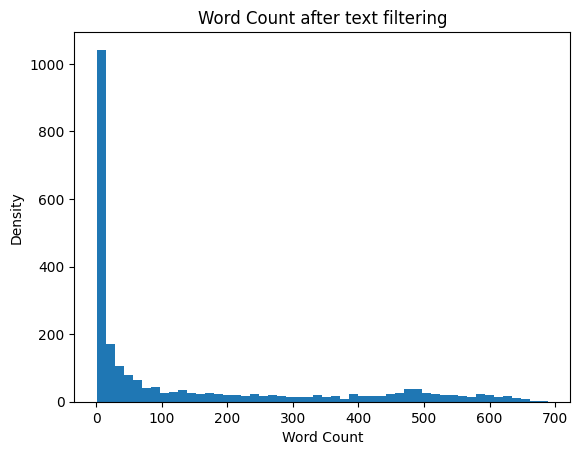

In [22]:
#split text into words and count them
df_filt['word_count'] = df_filt['filtered_text'].str.split().str.len()


#group by word count and count the number of rows in each group
word_count_distribution = df_filt.groupby('word_count').size()


#plot bar chart of word count distribution
word_count_distribution.plot(kind='hist', bins=50, density=False)

# plt.xlim(0, df_filt['word_count'].max())
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title("Word Count after text filtering")
plt.show()

In [10]:
print(df_filt['word_count'])

0         669
1         204
2         481
3         442
4         690
         ... 
331789    474
331790    203
331791    806
331792    623
331793    700
Name: word_count, Length: 331794, dtype: int64
